##Objective

Pick two pretrained CNN architectures, compare their specs, and apply one of them to a
small image classification task using transfer learning.

**Transfer Learning Showdown: MobileNetV2 vs ResNet50**

**Install required tensorflow library.**

In [1]:
!pip install tensorflow tensorflow-datasets

**Import Libraries.**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds

**Load CIFAR-10 dataset.**

In [3]:
(ds_train_full, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

class_names = ds_info.features['label'].names


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.1LN0T4_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.1LN0T4_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


**Preprocessing and splitting**

In [4]:
# Preprocessing and splitting
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_size = 0.8
train_count = int(ds_info.splits['train'].num_examples * train_size)

ds_train = ds_train_full.take(train_count)
ds_val = ds_train_full.skip(train_count)

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset = ds_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


**Final test split from validation.**

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(4 * val_batches // 5)
validation_dataset = validation_dataset.skip(4 * val_batches // 5)


**Load pretrained MobileNetV2.**

In [6]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Custom classification head.**

In [7]:
# Custom classification head
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])


**Check performance before training.**

In [8]:
loss0, accuracy0 = model.evaluate(validation_dataset)
print("Initial validation loss:", loss0)
print("Initial validation accuracy:", accuracy0)

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.0971 - loss: 2.7161
Initial validation loss: 2.6983611583709717
Initial validation accuracy: 0.1014999970793724


**Training callbacks.**

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('best_tuned_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

**Initial training.**

In [10]:
initial_epochs = 30

history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset,
    callbacks=[reduce_lr, checkpoint, early_stop]
)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1019 - loss: 2.4256
Epoch 1: val_loss improved from inf to 2.29974, saving model to best_tuned_model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 88s 65ms/step - accuracy: 0.1019 - loss: 2.4256 - val_accuracy: 0.1300 - val_loss: 2.2997 - learning_rate: 1.0000e-04
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0999 - loss: 2.3813
Epoch 2: val_loss improved from 2.29974 to 2.29843, saving model to best_tuned_model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 64ms/step - accuracy: 0.0999 - loss: 2.3813 - val_accuracy: 0.1015 - val_loss: 2.2984 - learning_rate: 1.0000e-04
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.1054 - loss: 2.3558
Epoch 3: val_loss improved from 2.29843 to 2.29829, saving model to best_tuned_model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - accuracy: 0.1054 - loss: 2.3558 - val_accuracy: 0.1015 - val_loss: 2.2983 - learning_rate: 1.0000e-04
Epoch 4/30
1250/

**Evaluate on test set.**

In [11]:
loss1, accuracy1 = model.evaluate(test_dataset)
print("Test loss:", loss1)
print("Test accuracy:", accuracy1)

250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.2178 - loss: 2.2307
Test loss: 2.230821371078491
Test accuracy: 0.2188750058412552


**Plot accuracy and loss.**

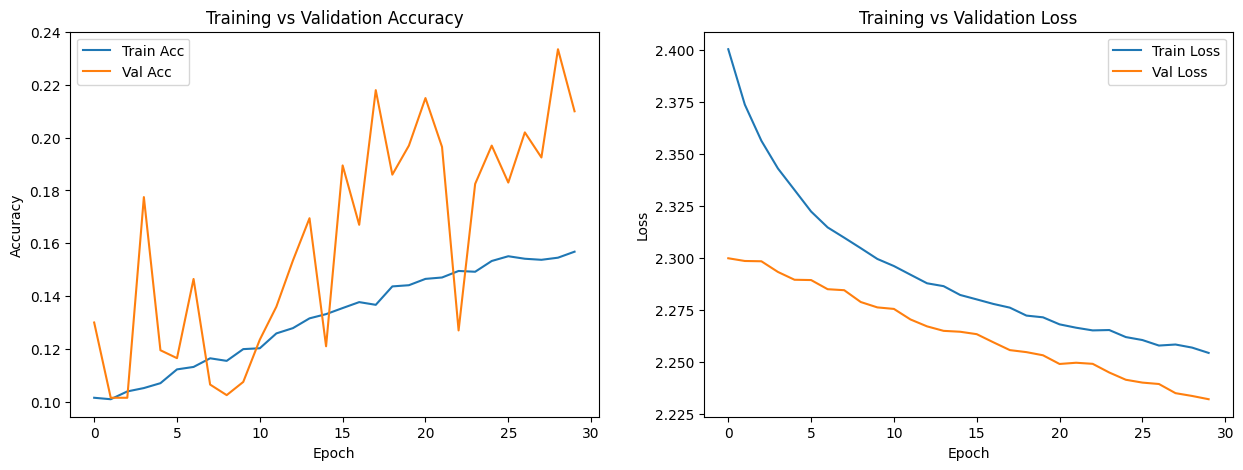

In [12]:
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Train Acc')
plt.plot(history_df['val_accuracy'], label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()


**Confusion Matrix.**

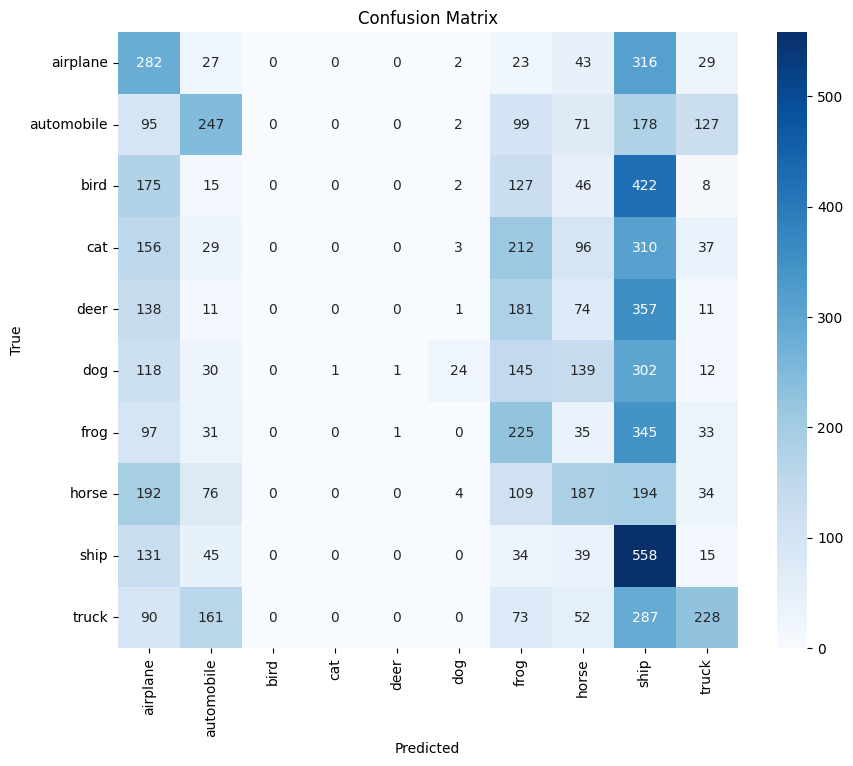

In [13]:
from sklearn.metrics import confusion_matrix

y_true, y_pred = [], []
for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


##Fine-Tuning Step.

**Fine-tune top layers**

In [14]:
base_model.trainable = True
fine_tune_at = 100  # freeze layers before this index
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile again with a low learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Continue training
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset,
    callbacks=[reduce_lr, checkpoint, early_stop]
)


Epoch 30/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.2040 - loss: 2.8633
Epoch 30: val_loss did not improve from 2.23189
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 144s 103ms/step - accuracy: 0.2040 - loss: 2.8628 - val_accuracy: 0.1010 - val_loss: 5.4633 - learning_rate: 1.0000e-05
Epoch 31/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3142 - loss: 1.9108
Epoch 31: val_loss did not improve from 2.23189
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 130s 103ms/step - accuracy: 0.3142 - loss: 1.9108 - val_accuracy: 0.1265 - val_loss: 3.3207 - learning_rate: 1.0000e-05
Epoch 32/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.3409 - loss: 1.8408
Epoch 32: val_loss did not improve from 2.23189
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 132s 105ms/step - accuracy: 0.3409 - loss: 1.8408 - val_accuracy: 0.1230 - val_loss: 3.4787 - learning_rate: 1.0000e-05
Epoch 33/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.3650 - loss: 1.7887
Epoch 33: val_loss did not improve from 2.